# **Final Project Notebook**
## *Climate Change Dataset*

In [3]:
#Imports

# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller


# Train/Test Splitting
from sklearn.model_selection import train_test_split

# Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense,TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Visulaizations
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [2]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.0 MB/s eta 0:00:00


In [4]:
from tcn import TCN


#### 1) Reading the Dataset

In [10]:
df = pd.read_csv('/climate.csv')
df.set_index('date', inplace=True)
df.head(10)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000
2013-01-07,7.000000,78.600000,6.300000,1020.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286
2013-01-09,14.000000,51.250000,12.500000,1017.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


#### 2) Explore the Dataset

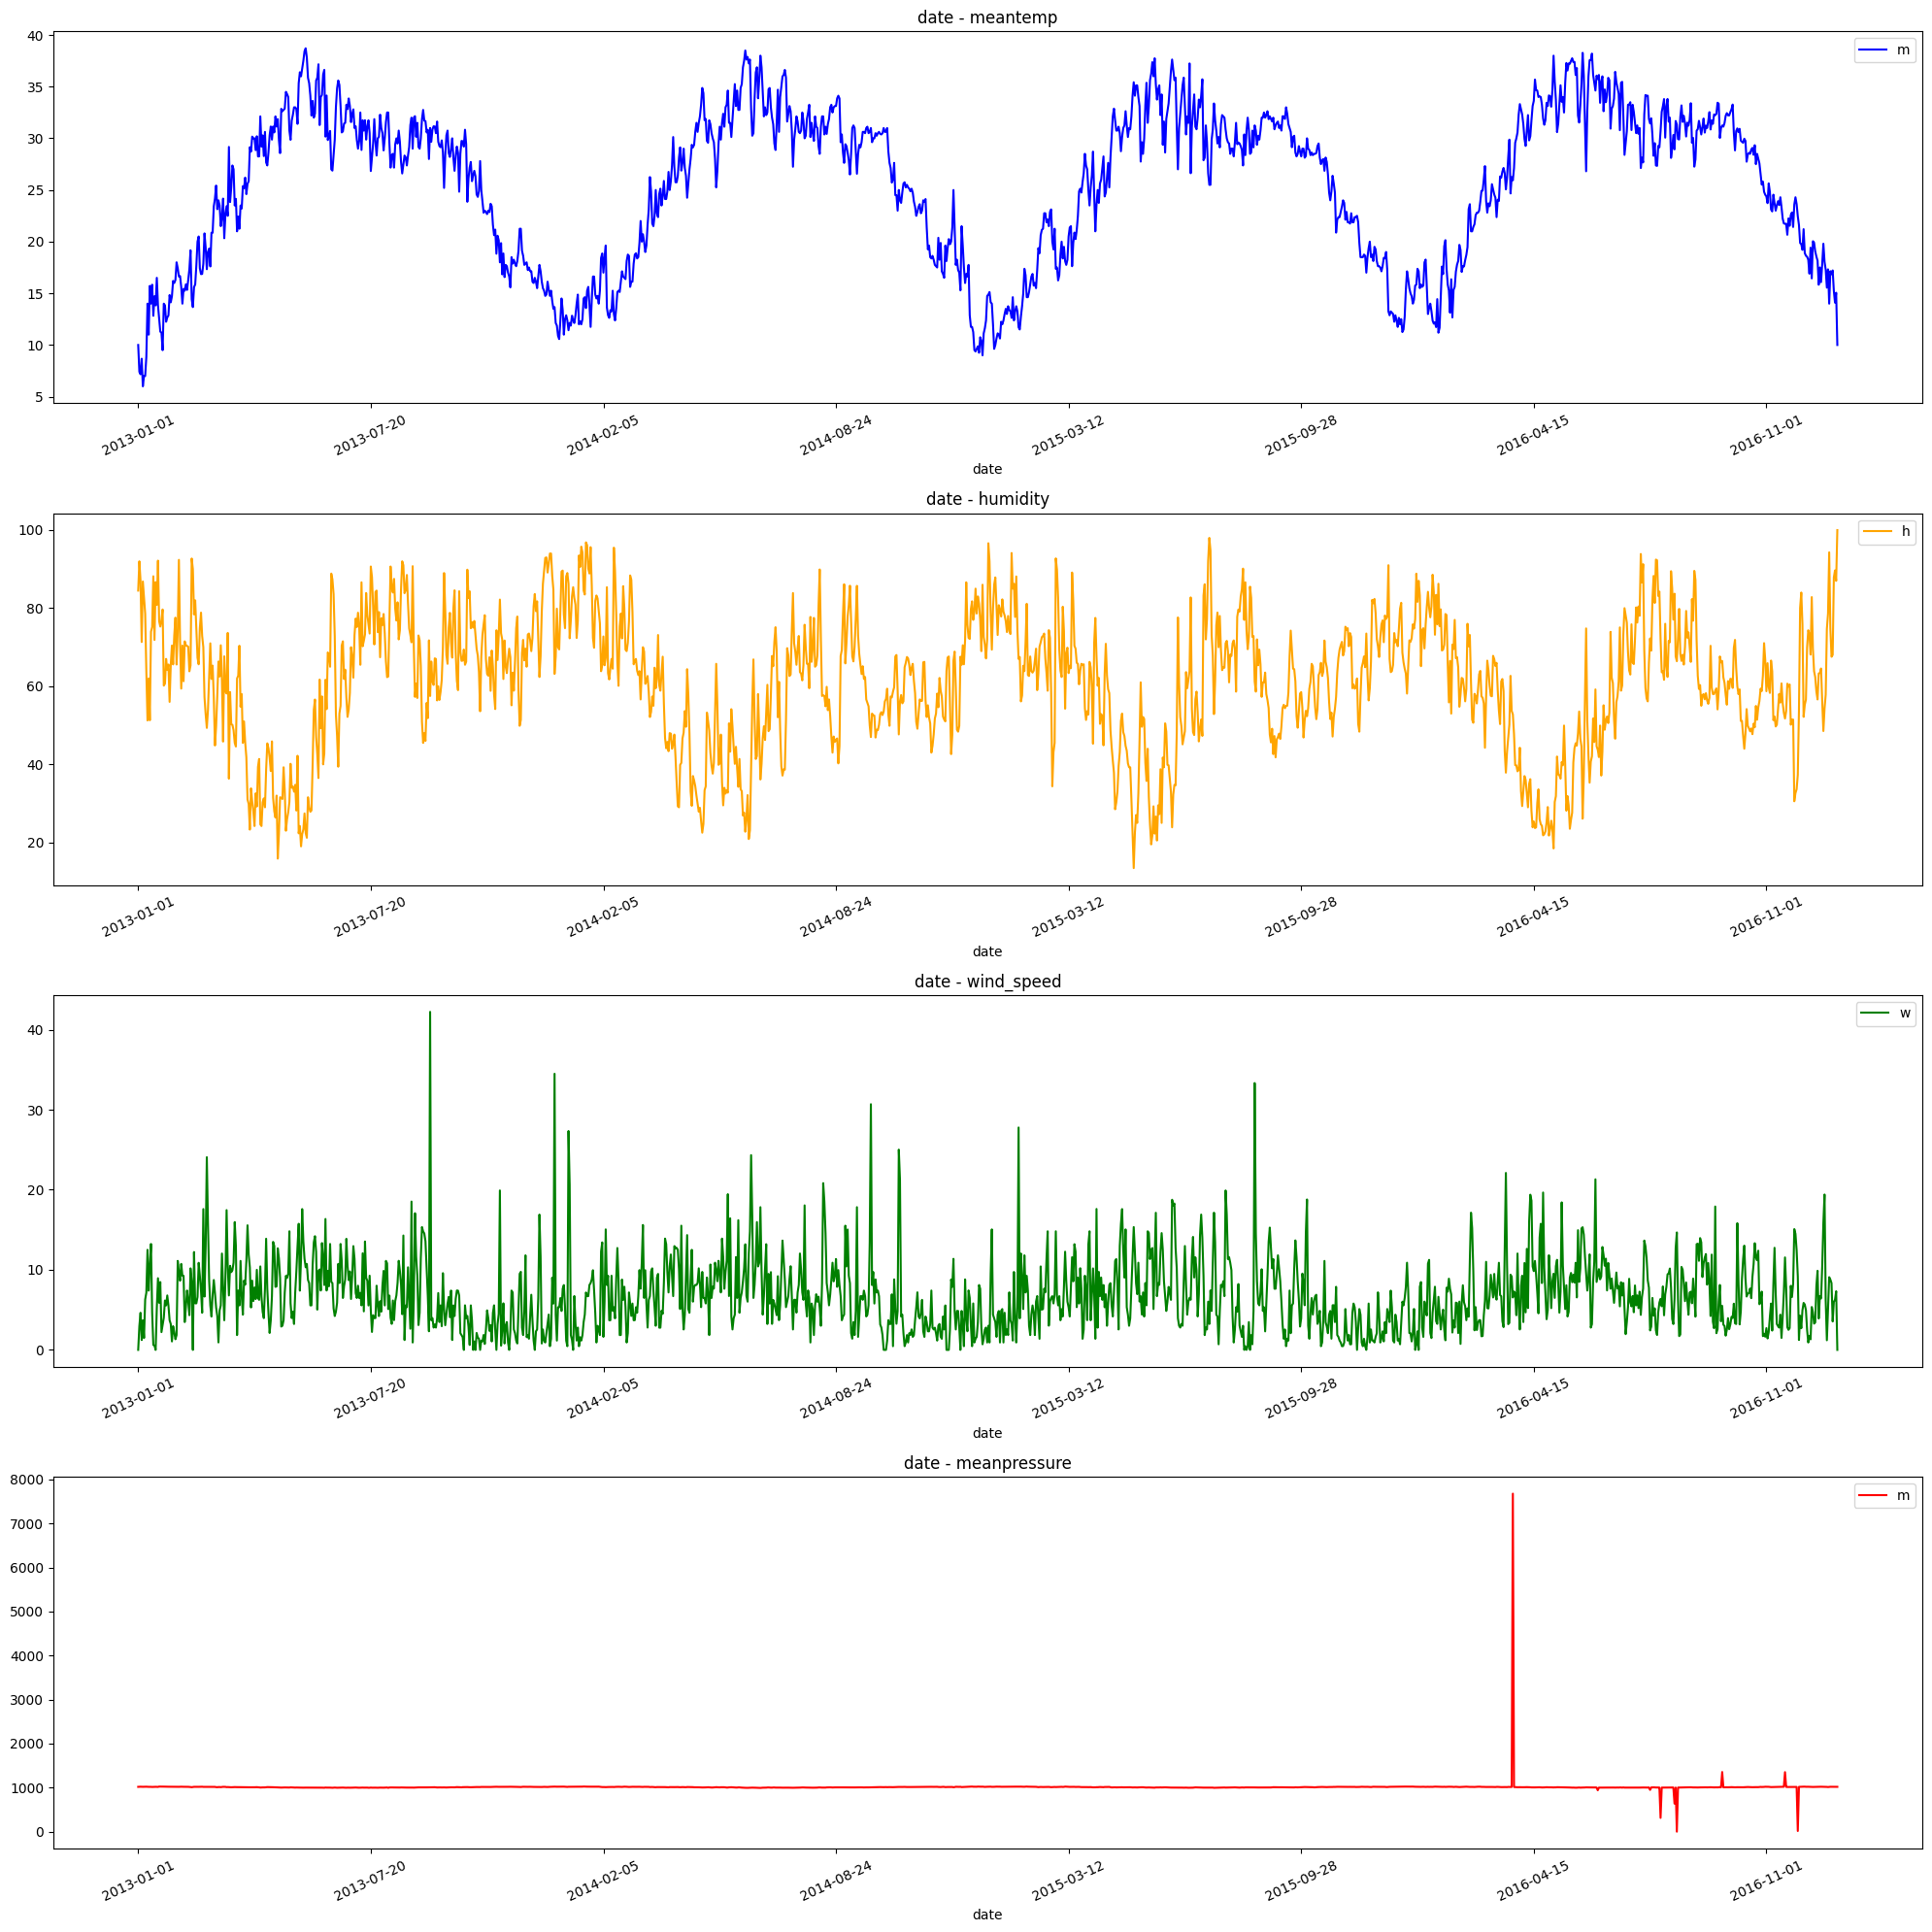

In [12]:
COLORS = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

def create_vizualizations(data : pd.DataFrame):
    columns = list(data.columns)
    x = data.index
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(20, 20), facecolor='w', edgecolor='k')
    for idx, col in enumerate(columns):
        ax = data[col].plot(ax=axes[idx], color=COLORS[idx], title=f'{x.name} - {col}', rot=25)
        ax.legend(col)
    plt.tight_layout()

create_vizualizations(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


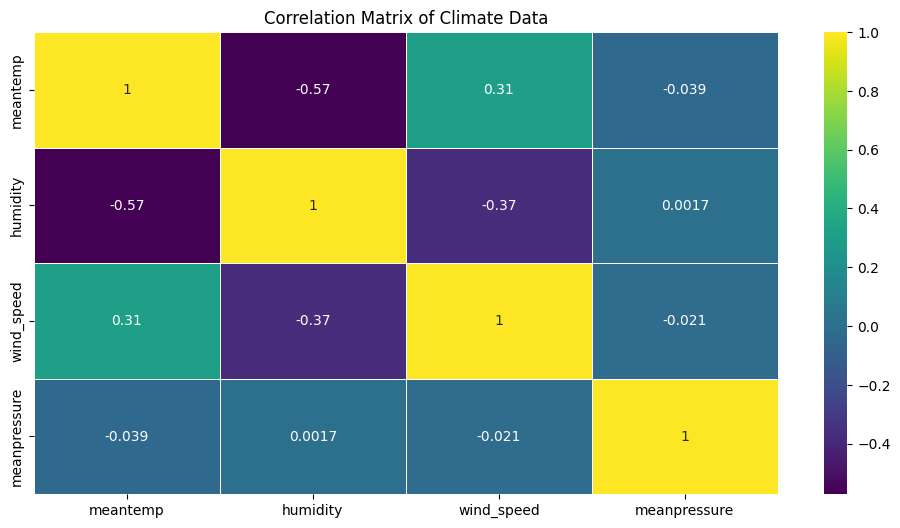

In [14]:
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Climate Data')
plt.show()

In [15]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [16]:
print(df.columns)

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


- Checking for null data

In [17]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

- Normalize the data

In [18]:
scaler = MinMaxScaler()
columns_to_scale = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaled_df = scaler.fit_transform(df[columns_to_scale])
# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=columns_to_scale)
scaled_df.head()

,meantemp,humidity,wind_speed,meanpressure
0,0.122271,0.820957,0.000000,0.132603
1,0.042795,0.907591,0.070583,0.132881
2,0.035662,0.849835,0.109743,0.132994
3,0.081514,0.668867,0.029212,0.132799
4,0.000000,0.847910,0.087636,0.132712


#### 4) Models

 - Check for Stationarity
     - Augmented Dickey-Fuller

In [19]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [20]:
for name, column in scaled_df.items():
    Augmented_Dickey_Fuller_Test_func(column,name)
    print('\n')

Results of Dickey-Fuller Test for column: meantemp
Test Statistic                   -2.021069
p-value                           0.277412
No Lags Used                     10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: humidity
Test Statistic                   -3.675577
p-value                           0.004470
No Lags Used                     15.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: wind_speed
Test Statistic                   -3.838097
p-value                     

*Since Data is staionary. There is no need for differencing.*



> **Multivariate Timeseries**



- Create sequences

In [21]:
scaled_df = scaler.fit_transform(df[columns_to_scale])
scaled_df = pd.DataFrame(scaled_df, columns=columns_to_scale)
def create_sequences(df, seq_length, label_col):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df[label_col].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
LABEL_COLUMN = 'meantemp'  # specify the column to use as the label
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH, LABEL_COLUMN)
sequences.shape, labels.shape

((1438, 24, 4), (1438,))

- Train/Test Split

In [22]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

- RNN Model

In [23]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Simple RNN Model Training
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
29/29 [==============================] - 3s 35ms/step - loss: 0.0276 - val_loss: 0.0063
Epoch 2/20
29/29 [==============================] - 1s 25ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 3/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 4/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 5/20
29/29 [==============================] - 1s 25ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 6/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/20
29/29 [==============================] - 1s 27ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/20
29/29 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 9/20
29/29 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 11/

- RNN Model Evaluation

In [24]:
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

9/9 [==============================] - 0s 5ms/step
Simple RNN - R² Score: 0.8828577334954935
Simple RNN - Mean Absolute Error (MAE): 0.04601732651917588
Simple RNN - Mean Squared Error (MSE): 0.0035345719765917443
Simple RNN - Root Mean Squared Error (RMSE): 0.059452266370524046


- Actual Vs Predicted Consumption

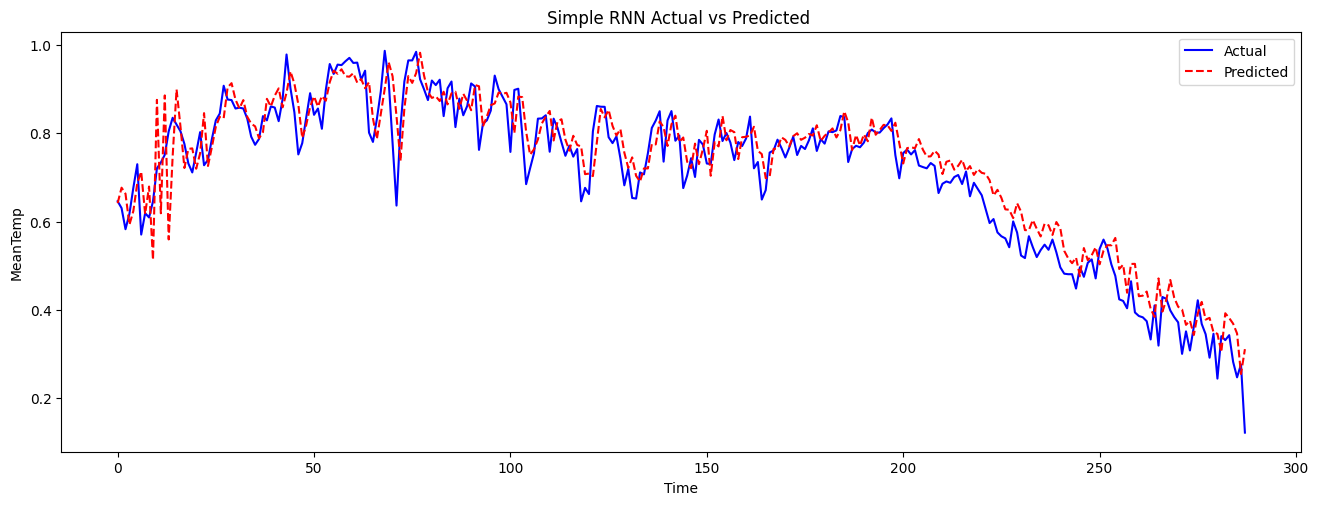

In [25]:
plt.figure(figsize=(16, 12))
# Simple RNN
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rnn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('Simple RNN Actual vs Predicted ')
plt.xlabel('Time')
plt.ylabel('MeanTemp')
plt.legend()

- LSTM Model

In [26]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# LSTM Model Training
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
29/29 [==============================] - 6s 61ms/step - loss: 0.0628 - val_loss: 0.0083
Epoch 2/20
29/29 [==============================] - 1s 28ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 3/20
29/29 [==============================] - 1s 27ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 4/20
29/29 [==============================] - 1s 28ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 5/20
29/29 [==============================] - 1s 27ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 6/20
29/29 [==============================] - 1s 32ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 7/20
29/29 [==============================] - 1s 44ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/20
29/29 [==============================] - 1s 45ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 9/20
29/29 [==============================] - 1s 46ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 10/20
29/29 [==============================] - 1s 41ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 11/

- LSTM Model Evaluation

In [27]:
lstm_predictions = lstm_model.predict(X_test)

# Calculate evaluation metrics for LSTM
lstm_r2 = r2_score(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f'LSTM - R² Score: {lstm_r2}')
print(f'LSTM - Mean Absolute Error (MAE): {lstm_mae}')
print(f'LSTM - Mean Squared Error (MSE): {lstm_mse}')
print(f'LSTM - Root Mean Squared Error (RMSE): {lstm_rmse}')

9/9 [==============================] - 2s 9ms/step
LSTM - R² Score: 0.856329937634129
LSTM - Mean Absolute Error (MAE): 0.052059360790807044
LSTM - Mean Squared Error (MSE): 0.0043350038501607764
LSTM - Root Mean Squared Error (RMSE): 0.06584074612396777


- Actual Vs Predicted Consumption

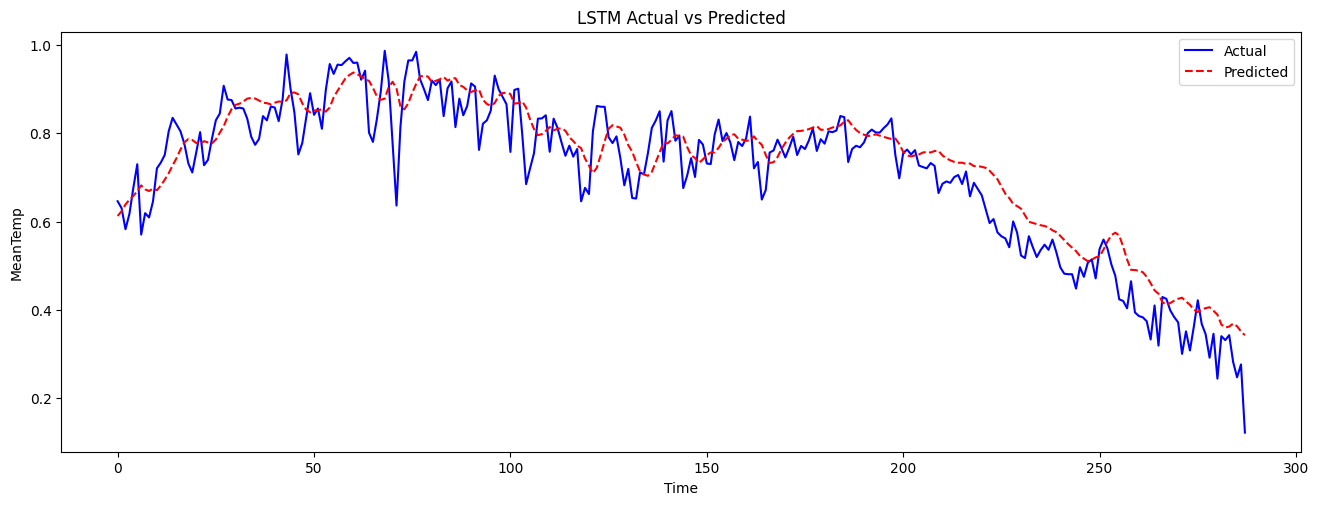

In [28]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(lstm_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('LSTM Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('MeanTemp')
plt.legend()

- TCN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tcn import TCN

In [33]:
tcn_model = Sequential([
    TCN(50, input_shape=(SEQ_LENGTH, X_train.shape[2]), return_sequences=True),  # Adjust parameters as per your library's requirements
    TCN(50),
    Dense(1)
])

# Compile the model
tcn_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the TCN model
tcn_history = tcn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
29/29 [==============================] - 12s 106ms/step - loss: 42.8500 - val_loss: 0.1456
Epoch 2/20
29/29 [==============================] - 2s 75ms/step - loss: 0.1451 - val_loss: 0.0541
Epoch 3/20
29/29 [==============================] - 2s 75ms/step - loss: 0.0582 - val_loss: 0.0335
Epoch 4/20
29/29 [==============================] - 5s 181ms/step - loss: 0.0427 - val_loss: 0.0275
Epoch 5/20
29/29 [==============================] - 4s 135ms/step - loss: 0.0355 - val_loss: 0.0278
Epoch 6/20
29/29 [==============================] - 2s 74ms/step - loss: 0.0304 - val_loss: 0.0227
Epoch 7/20
29/29 [==============================] - 2s 81ms/step - loss: 0.0264 - val_loss: 0.0229
Epoch 8/20
29/29 [==============================] - 2s 75ms/step - loss: 0.0236 - val_loss: 0.0193
Epoch 9/20
29/29 [==============================] - 3s 115ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 10/20
29/29 [==============================] - 3s 113ms/step - loss: 0.0184 - val_loss: 0.0189
Ep

- TCN Model Evaluation

In [34]:
# Make predictions with the TCN model
tcn_predictions = tcn_model.predict(X_test)

# Calculate evaluation metrics for TCN
tcn_r2 = r2_score(y_test, tcn_predictions)
tcn_mae = mean_absolute_error(y_test, tcn_predictions)
tcn_mse = mean_squared_error(y_test, tcn_predictions)
tcn_rmse = np.sqrt(tcn_mse)

print(f'TCN - R² Score: {tcn_r2}')
print(f'TCN - Mean Absolute Error (MAE): {tcn_mae}')
print(f'TCN - Mean Squared Error (MSE): {tcn_mse}')
print(f'TCN - Root Mean Squared Error (RMSE): {tcn_rmse}')

9/9 [==============================] - 1s 20ms/step
TCN - R² Score: 0.4149097774313951
TCN - Mean Absolute Error (MAE): 0.10179921325708224
TCN - Mean Squared Error (MSE): 0.017654118928877457
TCN - Root Mean Squared Error (RMSE): 0.13286880344489244


- Actual Vs Predicted Consumption

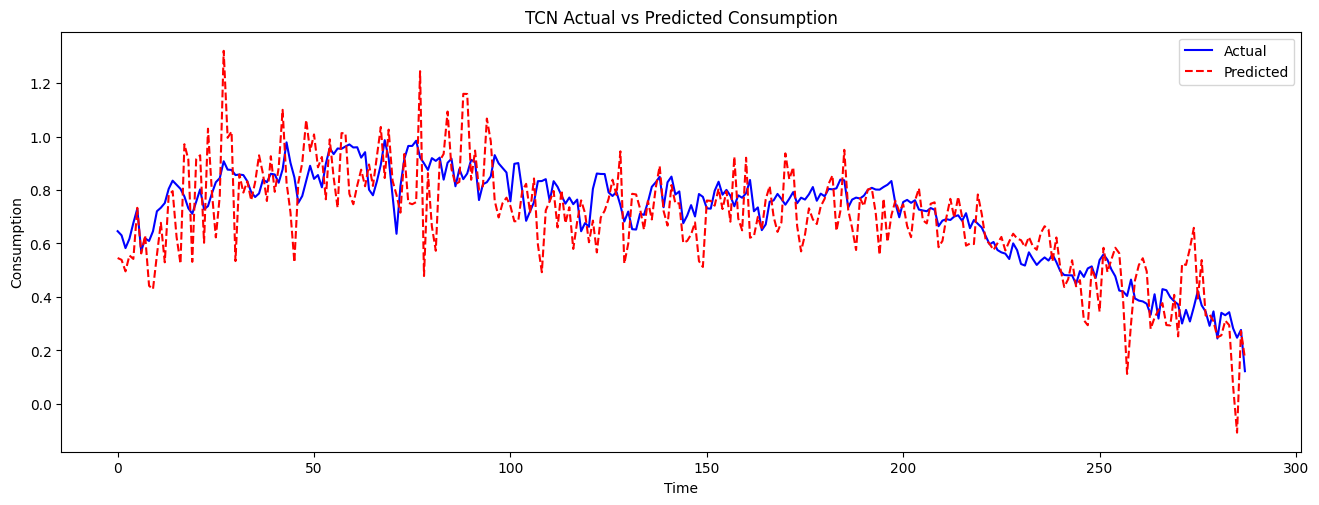

In [35]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(tcn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('TCN Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.legend()

In [36]:
rnn_metrics = {
    "Model": "Simple RNN",
    "R² Score": rnn_r2,
    "MAE": rnn_mae,
    "MSE": rnn_mse,
    "RMSE": rnn_rmse
}

lstm_metrics = {
    "Model": "LSTM",
    "R² Score": lstm_r2,
    "MAE": lstm_mae,
    "MSE": lstm_mse,
    "RMSE": lstm_rmse
}

tcn_metrics = {
    "Model": "TCN",
    "R² Score": tcn_r2,
    "MAE": tcn_mae,
    "MSE": tcn_mse,
    "RMSE": tcn_rmse
}

comparison_df = pd.DataFrame([rnn_metrics, lstm_metrics, tcn_metrics])
comparison_df.head()


,Model,R² Score,MAE,MSE,RMSE
0,Simple RNN,0.882858,0.046017,0.003535,0.059452
1,LSTM,0.856330,0.052059,0.004335,0.065841
2,TCN,0.414910,0.101799,0.017654,0.132869


In [37]:
# Function to highlight the best result per column
def highlight_best(s):
    is_best = s == s.min() if s.name in ["MAE", "MSE", "RMSE"] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

# Apply the highlighting function
comparison_df.style.apply(highlight_best, subset=["R² Score", "MAE", "MSE", "RMSE"])

,Model,R² Score,MAE,MSE,RMSE
0,Simple RNN,0.882858,0.046017,0.003535,0.059452
1,LSTM,0.856330,0.052059,0.004335,0.065841
2,TCN,0.414910,0.101799,0.017654,0.132869
